In [ ]:
# ;とか,のクレンジング
# [SEP] の前後にスペース、文末に文末に'.'
# 小文字

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    exp='001'
    wandb=True
    resume = None  # [None, 'auto', 'always']
    competition='PPPM'
    debug=False  # False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Wed Jun  1 13:12:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 4.5 MB/s 
CPU times: user 1.3 s, sys: 287 ms, total: 1.59 s
Wall time: 25.6 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume='auto',  # 'auto'
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 8.8 MB/s 
     |████████████████████████████████| 145 kB 52.4 MB/s 
     |████████████████████████████████| 181 kB 33.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...


# EDA

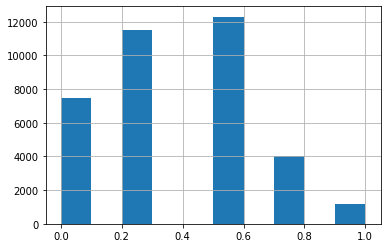

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, do_lower_case=True)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    # 'amp': amp.state_dict(),
                    'epoch': epoch,
                    'best_score': best_score},
                    checkpoint_path)
        # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'oof.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            torch.save({'fold': fold,
                        'oof_df': oof_df},
                        OUTPUT_DIR + 'oof.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 32m 55s) Loss: 0.6778(0.6778) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 20s (remain 21m 11s) Loss: 0.5296(0.6285) Grad: 39758.7617  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 39s (remain 19m 43s) Loss: 0.6273(0.6121) Grad: 96823.6484  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 3m 58s (remain 18m 21s) Loss: 0.5487(0.6000) Grad: 61719.1758  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 5m 16s (remain 17m 1s) Loss: 0.6464(0.5933) Grad: 83038.8125  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 6m 35s (remain 15m 41s) Loss: 0.4022(0.5846) Grad: 71341.2891  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 7m 54s (remain 14m 21s) Loss: 0.6018(0.5775) Grad: 59423.5156  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 9m 13s (remain 13m 3s) Loss: 0.5496(0.5740) Grad: 99849.8359  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 10m 32s (remain 11m 44s) Loss: 0.5985(0.5718) Grad: 134175.5312  LR: 0.00001932  
Epoch: [1][900/1693] Elapsed 

Epoch 1 - avg_train_loss: 0.5570  avg_val_loss: 0.5463  time: 1457s
Epoch 1 - Score: 0.8311
Epoch 1 - Save Best Score: 0.8311 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 39m 42s) Loss: 0.5409(0.5409) Grad: 70937.6719  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 26s (remain 22m 50s) Loss: 0.5938(0.5174) Grad: 207597.1250  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 2m 46s (remain 20m 34s) Loss: 0.4214(0.5178) Grad: 65483.8281  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 5s (remain 18m 53s) Loss: 0.5077(0.5162) Grad: 70879.4219  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 5m 23s (remain 17m 23s) Loss: 0.5048(0.5161) Grad: 29328.7363  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 6m 42s (remain 15m 58s) Loss: 0.5522(0.5152) Grad: 46550.1367  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 8m 1s (remain 14m 35s) Loss: 0.4723(0.5160) Grad: 88897.5703  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 9m 20s (remain 13m 13s) Loss: 0.6513(0.5155) Grad: 103837.2422  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 10m 39s (remain 11m 51s) Loss: 0.6324(0.5179) Grad: 17249.4512  LR: 0.00001402  
Epoch: [2][900/1693] 

Epoch 2 - avg_train_loss: 0.5192  avg_val_loss: 0.5479  time: 1463s
Epoch 2 - Score: 0.8373


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6798(0.5479) 


Epoch 2 - Save Best Score: 0.8373 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 43m 50s) Loss: 0.5466(0.5466) Grad: 72245.3281  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 23s (remain 21m 55s) Loss: 0.4068(0.5001) Grad: 223469.7344  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 2m 43s (remain 20m 15s) Loss: 0.5166(0.4989) Grad: 49442.8203  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 2s (remain 18m 41s) Loss: 0.5257(0.4985) Grad: 31526.5195  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 5m 21s (remain 17m 15s) Loss: 0.5025(0.5001) Grad: 22616.4648  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 6m 40s (remain 15m 52s) Loss: 0.5181(0.4987) Grad: 63737.4141  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 7m 59s (remain 14m 30s) Loss: 0.4905(0.5000) Grad: 38691.5586  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 9m 18s (remain 13m 9s) Loss: 0.4507(0.5004) Grad: 44751.4258  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 10m 36s (remain 11m 49s) Loss: 0.4728(0.5027) Grad: 27770.5801  LR: 0.00000637  
Epoch: [3][900/1693] E

Epoch 3 - avg_train_loss: 0.5028  avg_val_loss: 0.5543  time: 1461s
Epoch 3 - Score: 0.8393


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6769(0.5543) 


Epoch 3 - Save Best Score: 0.8393 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 38m 59s) Loss: 0.3963(0.3963) Grad: 17597.6270  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 23s (remain 21m 54s) Loss: 0.4648(0.5060) Grad: 64114.0391  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 2m 44s (remain 20m 19s) Loss: 0.5100(0.5003) Grad: 49306.9336  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 3s (remain 18m 44s) Loss: 0.5416(0.4987) Grad: 31594.1387  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 5m 22s (remain 17m 18s) Loss: 0.5170(0.4968) Grad: 31016.3320  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 6m 41s (remain 15m 54s) Loss: 0.5952(0.4972) Grad: 60341.8438  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 8m 0s (remain 14m 32s) Loss: 0.6415(0.4971) Grad: 32117.7969  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 9m 19s (remain 13m 11s) Loss: 0.4542(0.4959) Grad: 88922.9141  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 10m 38s (remain 11m 50s) Loss: 0.3898(0.4954) Grad: 26571.3164  LR: 0.00000085  
Epoch: [4][900/1693] El

Epoch 4 - avg_train_loss: 0.4962  avg_val_loss: 0.5648  time: 1465s
Epoch 4 - Score: 0.8354


EVAL: [586/587] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6763(0.5648) 


========== fold: 0 result ==========
Score: 0.8393
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 42m 31s) Loss: 0.7813(0.7813) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 23s (remain 22m 23s) Loss: 0.6428(0.6286) Grad: 45140.4180  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 42s (remain 20m 31s) Loss: 0.5882(0.6077) Grad: 20853.2539  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 1s (remain 19m 1s) Loss: 0.6251(0.5954) Grad: 26684.6523  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 20s (remain 17m 37s) Loss: 0.6044(0.5869) Grad: 31297.9648  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 39s (remain 16m 15s) Loss: 0.5406(0.5808) Grad: 35420.8906  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 58s (remain 14m 54s) Loss: 0.5459(0.5775) Grad: 32937.5508  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 17s (remain 13m 34s) Loss: 0.5054(0.5745) Grad: 15573.2656  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 36s (remain 12m 13s) Loss: 0.4925(0.5703) Grad: 36441.2891  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 1

Epoch 1 - avg_train_loss: 0.5564  avg_val_loss: 0.5538  time: 1479s
Epoch 1 - Score: 0.8081


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5029(0.5538) 


Epoch 1 - Save Best Score: 0.8081 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 42m 10s) Loss: 0.4983(0.4983) Grad: 99702.4531  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 26s (remain 23m 8s) Loss: 0.5939(0.5279) Grad: 31368.0859  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 45s (remain 20m 52s) Loss: 0.5034(0.5251) Grad: 263243.6250  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 4s (remain 19m 14s) Loss: 0.5289(0.5227) Grad: 64638.9062  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 23s (remain 17m 46s) Loss: 0.5095(0.5199) Grad: 137345.6875  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 42s (remain 16m 23s) Loss: 0.6019(0.5176) Grad: 217314.1406  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 8m 1s (remain 15m 0s) Loss: 0.4081(0.5176) Grad: 84398.4922  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 20s (remain 13m 38s) Loss: 0.5823(0.5157) Grad: 205441.6875  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 39s (remain 12m 17s) Loss: 0.6068(0.5158) Grad: 158601.2656  LR: 0.00001409  
Epoch: [2][900/1725]

Epoch 2 - avg_train_loss: 0.5147  avg_val_loss: 0.5693  time: 1486s
Epoch 2 - Score: 0.8170


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.4980(0.5693) 


Epoch 2 - Save Best Score: 0.8170 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 35m 50s) Loss: 0.5807(0.5807) Grad: 205224.5938  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 23s (remain 22m 23s) Loss: 0.4184(0.5065) Grad: 66235.7969  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 44s (remain 20m 48s) Loss: 0.4844(0.5099) Grad: 52523.8203  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 3s (remain 19m 12s) Loss: 0.4864(0.5111) Grad: 49437.2461  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 22s (remain 17m 44s) Loss: 0.5037(0.5125) Grad: 194276.3438  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 41s (remain 16m 20s) Loss: 0.5543(0.5100) Grad: 29122.0820  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 8m 0s (remain 14m 58s) Loss: 0.4838(0.5078) Grad: 63185.9570  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 19s (remain 13m 37s) Loss: 0.5243(0.5080) Grad: 105997.6250  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 38s (remain 12m 16s) Loss: 0.5027(0.5065) Grad: 27974.8184  LR: 0.00000644  
Epoch: [3][900/1725]

Epoch 3 - avg_train_loss: 0.5035  avg_val_loss: 0.5646  time: 1483s
Epoch 3 - Score: 0.8235


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.4957(0.5646) 


Epoch 3 - Save Best Score: 0.8235 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 42m 36s) Loss: 0.4597(0.4597) Grad: 50218.1133  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 25s (remain 22m 51s) Loss: 0.5957(0.4994) Grad: 59767.2773  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 45s (remain 20m 51s) Loss: 0.2933(0.5003) Grad: 26491.7891  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 4s (remain 19m 14s) Loss: 0.5729(0.5008) Grad: 59284.4922  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 22s (remain 17m 46s) Loss: 0.4172(0.5006) Grad: 21098.7773  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 41s (remain 16m 21s) Loss: 0.4920(0.5017) Grad: 32295.7207  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 8m 0s (remain 14m 59s) Loss: 0.4874(0.5011) Grad: 40508.7891  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 19s (remain 13m 37s) Loss: 0.4571(0.5006) Grad: 46296.1836  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 38s (remain 12m 16s) Loss: 0.4943(0.5008) Grad: 35654.3164  LR: 0.00000088  
Epoch: [4][900/1725] El

Epoch 4 - avg_train_loss: 0.4974  avg_val_loss: 0.5766  time: 1483s
Epoch 4 - Score: 0.8203


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.4990(0.5766) 


========== fold: 1 result ==========
Score: 0.8235
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 46m 7s) Loss: 0.7157(0.7157) Grad: 104327.5938  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 23s (remain 22m 30s) Loss: 0.7159(0.6401) Grad: 69806.6406  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 42s (remain 20m 42s) Loss: 0.5699(0.6076) Grad: 78299.9844  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 1s (remain 19m 13s) Loss: 0.5918(0.5951) Grad: 69306.7344  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 5m 20s (remain 17m 49s) Loss: 0.6527(0.5862) Grad: 41691.6602  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 6m 39s (remain 16m 27s) Loss: 0.5869(0.5829) Grad: 59200.4609  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 7m 57s (remain 15m 6s) Loss: 0.6402(0.5783) Grad: 77589.3828  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 9m 16s (remain 13m 46s) Loss: 0.5883(0.5743) Grad: 51858.2812  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 10m 35s (remain 12m 26s) Loss: 0.4380(0.5711) Grad: 28634.9648  LR: 0.00001935  
Epoch: [1][900/1741] El

Epoch 1 - avg_train_loss: 0.5567  avg_val_loss: 0.5376  time: 1488s
Epoch 1 - Score: 0.8344


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3678(0.5376) 


Epoch 1 - Save Best Score: 0.8344 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 48m 20s) Loss: 0.3659(0.3659) Grad: 66289.0938  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 27s (remain 23m 47s) Loss: 0.5126(0.5206) Grad: 42051.2695  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 2m 46s (remain 21m 17s) Loss: 0.5007(0.5142) Grad: 158569.4531  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 5s (remain 19m 35s) Loss: 0.4806(0.5143) Grad: 59101.2656  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 5m 24s (remain 18m 4s) Loss: 0.3410(0.5113) Grad: 62252.6914  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 6m 43s (remain 16m 38s) Loss: 0.4792(0.5123) Grad: 36856.7891  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 8m 2s (remain 15m 15s) Loss: 0.6172(0.5109) Grad: 89599.0859  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 9m 21s (remain 13m 53s) Loss: 0.4908(0.5119) Grad: 52186.2617  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 10m 40s (remain 12m 31s) Loss: 0.5424(0.5133) Grad: 37894.4453  LR: 0.00001412  
Epoch: [2][900/1741] El

Epoch 2 - avg_train_loss: 0.5182  avg_val_loss: 0.5486  time: 1493s
Epoch 2 - Score: 0.8430


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3622(0.5486) 


Epoch 2 - Save Best Score: 0.8430 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 42m 20s) Loss: 0.5719(0.5719) Grad: 57326.3125  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 27s (remain 23m 44s) Loss: 0.4858(0.4962) Grad: 87571.1719  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 2m 46s (remain 21m 17s) Loss: 0.5135(0.5018) Grad: 29770.9141  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 5s (remain 19m 35s) Loss: 0.4572(0.4968) Grad: 67185.5859  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 5m 24s (remain 18m 3s) Loss: 0.5048(0.4972) Grad: 63939.3750  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 6m 43s (remain 16m 38s) Loss: 0.4647(0.4987) Grad: 29651.1328  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 8m 2s (remain 15m 14s) Loss: 0.5681(0.4997) Grad: 54376.1016  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 9m 21s (remain 13m 52s) Loss: 0.6440(0.4996) Grad: 48403.7383  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 10m 39s (remain 12m 30s) Loss: 0.6012(0.5017) Grad: 41451.4766  LR: 0.00000647  
Epoch: [3][900/1741] Ela

Epoch 3 - avg_train_loss: 0.5054  avg_val_loss: 0.5511  time: 1492s
Epoch 3 - Score: 0.8448


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3495(0.5511) 


Epoch 3 - Save Best Score: 0.8448 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 46m 46s) Loss: 0.4478(0.4478) Grad: 220054.6250  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 25s (remain 23m 10s) Loss: 0.5152(0.4952) Grad: 41649.0156  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 2m 45s (remain 21m 9s) Loss: 0.6200(0.4972) Grad: 93036.7578  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 4m 4s (remain 19m 30s) Loss: 0.5368(0.4969) Grad: 126006.8203  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 5m 23s (remain 18m 1s) Loss: 0.5758(0.4978) Grad: 57850.4375  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 6m 42s (remain 16m 36s) Loss: 0.4748(0.4966) Grad: 50107.8906  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 8m 1s (remain 15m 13s) Loss: 0.4444(0.4960) Grad: 58476.2578  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 9m 20s (remain 13m 51s) Loss: 0.4531(0.4966) Grad: 27110.4082  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 10m 39s (remain 12m 30s) Loss: 0.5754(0.4970) Grad: 30301.9531  LR: 0.00000089  
Epoch: [4][900/1741] El

Epoch 4 - avg_train_loss: 0.4982  avg_val_loss: 0.5562  time: 1492s
Epoch 4 - Score: 0.8430


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3442(0.5562) 


========== fold: 2 result ==========
Score: 0.8448
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 36m 52s) Loss: 0.8123(0.8123) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 23s (remain 21m 39s) Loss: 0.5258(0.6306) Grad: 33995.1445  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 42s (remain 19m 50s) Loss: 0.6109(0.6110) Grad: 52193.9883  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 4m 0s (remain 18m 22s) Loss: 0.6600(0.5939) Grad: 67577.3906  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 5m 19s (remain 16m 58s) Loss: 0.5183(0.5866) Grad: 22690.3770  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 6m 38s (remain 15m 36s) Loss: 0.5602(0.5821) Grad: 26933.1328  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 7m 57s (remain 14m 15s) Loss: 0.5752(0.5770) Grad: 15432.4102  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 9m 16s (remain 12m 55s) Loss: 0.6107(0.5721) Grad: 26833.6367  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 10m 35s (remain 11m 35s) Loss: 0.4420(0.5679) Grad: 31146.1152  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 

Epoch 1 - avg_train_loss: 0.5572  avg_val_loss: 0.5516  time: 1452s
Epoch 1 - Score: 0.8024
Epoch 1 - Save Best Score: 0.8024 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 45m 24s) Loss: 0.4721(0.4721) Grad: 18570.7227  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 26s (remain 22m 29s) Loss: 0.6882(0.5174) Grad: 286069.5000  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 2m 45s (remain 20m 16s) Loss: 0.5639(0.5154) Grad: 88205.9844  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 4s (remain 18m 38s) Loss: 0.5549(0.5133) Grad: 143779.8125  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 5m 23s (remain 17m 10s) Loss: 0.6302(0.5122) Grad: 387447.0000  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 6m 42s (remain 15m 46s) Loss: 0.5320(0.5138) Grad: 66580.4688  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 8m 1s (remain 14m 23s) Loss: 0.5750(0.5143) Grad: 98480.5312  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 9m 20s (remain 13m 1s) Loss: 0.5986(0.5158) Grad: 90166.2422  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 10m 40s (remain 11m 40s) Loss: 0.5081(0.5160) Grad: 72574.2188  LR: 0.00001399  
Epoch: [2][900/1678] 

Epoch 2 - avg_train_loss: 0.5165  avg_val_loss: 0.5545  time: 1456s
Epoch 2 - Score: 0.8141
Epoch 2 - Save Best Score: 0.8141 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 47m 30s) Loss: 0.5153(0.5153) Grad: 38643.0039  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 25s (remain 22m 20s) Loss: 0.5458(0.5088) Grad: 61825.7695  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 2m 45s (remain 20m 18s) Loss: 0.4355(0.5051) Grad: 61994.5977  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 4s (remain 18m 40s) Loss: 0.5514(0.5040) Grad: 50695.4883  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 5m 24s (remain 17m 12s) Loss: 0.5053(0.5036) Grad: 63640.8359  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 6m 43s (remain 15m 47s) Loss: 0.4321(0.5036) Grad: 43576.6680  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 8m 2s (remain 14m 24s) Loss: 0.4296(0.5033) Grad: 31544.4648  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 9m 21s (remain 13m 1s) Loss: 0.4895(0.5041) Grad: 83562.4766  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 10m 40s (remain 11m 40s) Loss: 0.5901(0.5035) Grad: 80687.6562  LR: 0.00000634  
Epoch: [3][900/1678] Ela

Epoch 3 - avg_train_loss: 0.5051  avg_val_loss: 0.5672  time: 1456s
Epoch 3 - Score: 0.8108


Epoch: [4][0/1678] Elapsed 0m 1s (remain 32m 50s) Loss: 0.5652(0.5652) Grad: 36484.7539  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 24s (remain 22m 4s) Loss: 0.4192(0.5041) Grad: 40427.2930  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 2m 43s (remain 20m 3s) Loss: 0.5923(0.5034) Grad: 63144.5664  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 2s (remain 18m 29s) Loss: 0.5054(0.5005) Grad: 48063.1914  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 5m 21s (remain 17m 3s) Loss: 0.4371(0.4992) Grad: 49930.8711  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 6m 40s (remain 15m 40s) Loss: 0.6233(0.4959) Grad: 393633.0625  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 7m 59s (remain 14m 18s) Loss: 0.5191(0.4963) Grad: 43822.3477  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 9m 17s (remain 12m 57s) Loss: 0.4101(0.4952) Grad: 70324.1719  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 10m 36s (remain 11m 37s) Loss: 0.5338(0.4955) Grad: 56368.6523  LR: 0.00000083  
Epoch: [4][900/1678] Ela

Epoch 4 - avg_train_loss: 0.4986  avg_val_loss: 0.5705  time: 1452s
Epoch 4 - Score: 0.8103
========== fold: 3 result ==========
Score: 0.8141
========== CV ==========
Score: 0.8300


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▂▄█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▇▇▆██▇▆▆▆▇▆▅█▄▅▇▅▆▂█▄▅▆▄▄▆▃▃▆▇▂▇▆▃▁▁▆▅
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆█▅
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▁▆▄█
[fold1] epoch,▁▃▆█
[fold1] loss,▆▄█▅▆▄▅▆▃▂▄▄▅▅▇▂▁▃▆▅▅▄▄▆▃▃▄▄▅▄▄▄▄▂▅▄▅▃▅▂
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.27k/2.27k [00:02<00:00, 1.05kB/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:04<00:00, 3.45kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:04<00:00, 606kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:03<00:00, 662B/s]
Upload successful: config.pth (2KB)
Starting upload for file checkpoint.pth
100% 4.86G/4.86G [01:39<00:00, 52.2MB/s]
Upload successful: checkpoint.pth (5GB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:37<00:00, 46.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file oof.pth
100% 10.4M/10.4M [00:04<00:00, 2.54MB/s]
Upload successful: oof.pth (10MB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:41<00:00, 42.0MB/s]
Upload successful: microsoft